In [1]:
!pip install git+https://github.com/Menelau/DESlib

  Cloning https://github.com/Menelau/DESlib to /tmp/pip-req-build-rptsnscc
  Running setup.py bdist_wheel for DESlib ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ln5r76u4/wheels/8d/97/f7/014976b54546aa3fc60da2446f9ab6f57727cf478172007b06
Successfully built DESlib


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

import sys
sys.path.insert(0, '../Lista2')
import kdn
import ih_classifier

from deslib.dcs.mcb import MCB
from deslib.dcs.ola import OLA
from deslib.des.knora_e import KNORAE
from deslib.des.des_knn import DESKNN

/home/CIN/jvcm/mcsenv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Pre processing

In [3]:
data = pd.read_csv('../cm1.csv')

In [4]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
len(X)

498

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Analysis

In [6]:
skf = StratifiedKFold(n_splits=10, shuffle=True)
metrics = np.zeros((5,4))

for train_index, test_index in skf.split(X, y):
       
    X_Train, X_test = X[train_index], X[test_index]
    y_Train, y_test = y[train_index], y[test_index]

    sm = SMOTE()
    X_Train, y_Train = sm.fit_sample(X_Train, y_Train)
    
    skf_val = StratifiedKFold(n_splits=5, shuffle=True)
    for train, val_index in skf.split(X_Train, y_Train):
        X_train, X_val = X_Train[train], X_Train[val_index]
        y_train, y_val = y_Train[train], y_Train[val_index]
        break
    
#-------------------------------IH MODEL--------------------------------
    ih_model = ih_classifier.IHClassifier()
    ih_model.fit(X_Train, y_Train)
    
#-----------------------------------------------------------------------

    bg = BaggingClassifier(Perceptron(max_iter = 150, tol = 0.001),
                         n_estimators = 100)
    bg.fit(X_train, y_train)
    
#-------------------------------DCS & DES-------------------------------
    ola = OLA(bg)
    ola.fit(X_val, y_val)
    
    mcb = MCB(bg)
    mcb.fit(X_val, y_val)
    
    knorae = KNORAE(bg)
    knorae.fit(X_val, y_val)
    
    desknn = DESKNN(bg)
    desknn.fit(X_val, y_val)
    
    models = [ih_model, ola, mcb, knorae, desknn]
            
#---------------------------------------------------------
    
    for i, model in enumerate(models):
        metrics[i, :] += np.array([accuracy_score(y_test, model.predict(X_test)),
                            roc_auc_score(y_test, model.predict(X_test)),
                            geometric_mean_score(y_test, model.predict(X_test)),
                            f1_score(y_test, model.predict(X_test))])
metrics = metrics/skf.n_splits

Easy-False: 269 Easy-True: 393 Hard-False: 135 Hard-True: 11
Easy-False: 269 Easy-True: 400 Hard-False: 135 Hard-True: 4
Easy-False: 286 Easy-True: 392 Hard-False: 118 Hard-True: 12
Easy-False: 275 Easy-True: 397 Hard-False: 129 Hard-True: 7
Easy-False: 273 Easy-True: 392 Hard-False: 131 Hard-True: 12
Easy-False: 259 Easy-True: 401 Hard-False: 145 Hard-True: 3
Easy-False: 274 Easy-True: 400 Hard-False: 130 Hard-True: 4
Easy-False: 277 Easy-True: 400 Hard-False: 127 Hard-True: 4
Easy-False: 269 Easy-True: 397 Hard-False: 135 Hard-True: 7
Easy-False: 268 Easy-True: 396 Hard-False: 137 Hard-True: 9


In [7]:
metrics

array([[0.757     , 0.67363636, 0.64829212, 0.31750223],
       [0.74858333, 0.69573232, 0.67256625, 0.3291653 ],
       [0.73891667, 0.66378788, 0.67450448, 0.30153666],
       [0.73508333, 0.6575    , 0.62954621, 0.28958647],
       [0.74283333, 0.69742424, 0.67484216, 0.32318854]])

### Results

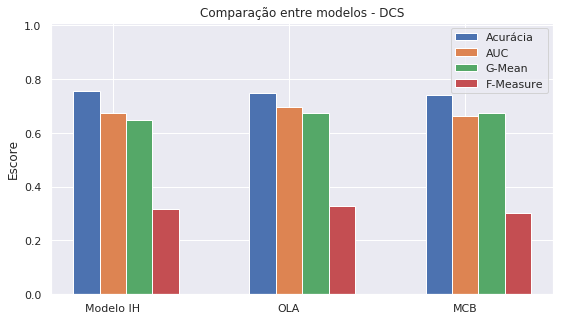

           Acurácia       AUC    G-Mean  F-Measure
Modelo IH  0.757000  0.673636  0.648292   0.317502
OLA        0.748583  0.695732  0.672566   0.329165
MCB        0.738917  0.663788  0.674504   0.301537


In [8]:
rcParams['figure.figsize'] = 9, 5
barWidth = 0.15
# Set position of bar on X axis
r1 = np.arange(metrics[:3].shape[0])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, metrics[:3, 0], width=barWidth, edgecolor='white', label='Acurácia')
plt.bar(r2, metrics[:3, 1], width=barWidth, edgecolor='white', label='AUC')
plt.bar(r3, metrics[:3, 2], width=barWidth, edgecolor='white', label='G-Mean')
plt.bar(r4, metrics[:3, 3], width=barWidth, edgecolor='white', label='F-Measure')

# Add xticks on the middle of the group bars
plt.ylim([0., 1.01])
plt.xlim([-0.2, 2.65])
plt.ylabel('Escore')
plt.xticks([r + barWidth for r in range(metrics[:3].shape[0])], ['Modelo IH', 'OLA', 'MCB'])

# Create legend & Show graphic
plt.legend(loc = 'upper right')
plt.title('Comparação entre modelos - DCS')
plt.show()

df = pd.DataFrame(data = metrics[:3], columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'], index = ['Modelo IH', 'OLA', 'MCB'])
print(df)

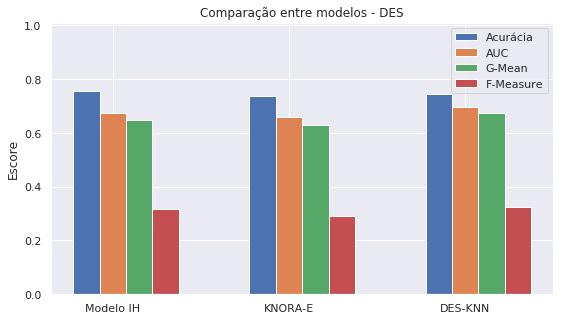

           Acurácia       AUC    G-Mean  F-Measure
Modelo IH  0.757000  0.673636  0.648292   0.317502
KNORA-E    0.735083  0.657500  0.629546   0.289586
DES-KNN    0.742833  0.697424  0.674842   0.323189


In [9]:
rcParams['figure.figsize'] = 9, 5
barWidth = 0.15
# Set position of bar on X axis
r1 = np.arange(metrics[:3].shape[0])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, metrics[[0,3,4], 0], width=barWidth, edgecolor='white', label='Acurácia')
plt.bar(r2, metrics[[0,3,4], 1], width=barWidth, edgecolor='white', label='AUC')
plt.bar(r3, metrics[[0,3,4], 2], width=barWidth, edgecolor='white', label='G-Mean')
plt.bar(r4, metrics[[0,3,4], 3], width=barWidth, edgecolor='white', label='F-Measure')

# Add xticks on the middle of the group bars
plt.ylim([0., 1.01])
plt.xlim([-0.2, 2.65])
plt.ylabel('Escore')
plt.xticks([r + barWidth for r in range(metrics[:3].shape[0])], ['Modelo IH', 'KNORA-E', 'DES-KNN'])

# Create legend & Show graphic
plt.legend(loc = 'upper right')
plt.title('Comparação entre modelos - DES')
plt.show()

df = pd.DataFrame(data = metrics[[0,3,4]], columns = ['Acurácia', 'AUC', 'G-Mean', 'F-Measure'], index = ['Modelo IH', 'KNORA-E', 'DES-KNN'])
print(df)